University of Zagreb<br/>
Faculty of Electrical Engineering and Computing<br/>
Department of Electronic Systems and Information Processing

Academic year 2023/2024

## **2nd laboratory exercise: Image transforms/image enhancement**

*Digital Image Processing and Analysis*

Date: 2024-04-10

Please send any feedback (corrections, comments, suggestions etc.) regarding this document to ivana.matovinovic@fer.hr.

© University of Zagreb Faculty of Electrical Engineering and Computing, 2024.

Permission is granted to make and distribute copies of this instructions provided the copyright notice and this permission notice are preserved on all copies.

# Introduction

Instructions for laboratory exercises for the course *Digital Image Processing and Analysis* are prepared in a form of a <a href="https://jupyter.org/">Jupyter</a> notebooks.

All problems in prepared notebook are intended to be completed in Python using <a href="https://colab.research.google.com">Google Colaboratory</a> platform (Colab for short).

## How to Submit Your Laboratory Report

Simply write-in your code to all empty code cells and write in your answers to the text cells with questions.

Empty code cells contain the placeholder text `# Write-in your solution` while text cells where you have to write-in someting contain a bold uppercase text **WRITE YOUR ANSWER HERE**.

Once you have completed all problems save this notebook locally in a file named DIPA_LAB_X_NAME_SURNAME.ipynb,
where X is the exercise number, and submit it via Moodle under the appropriate upload section.

Your submissions will be first automatically re-evaluated which corresponds to selecting the *Runtime/Restart and run all* command in Colab. Therefore, it is strongly suggested that you run this command yourself before submitting your notebook. Another thing to do before submission is to clear all the cell outputs by selecting *Edit/Clear all outputs*. This will reduce the size of .ipynb files for upload.

## Student Information

Before proceeding double click on this text and then fill in your name:

Name: **NAME & SURNAME**

Student ID number (JMBAG): **0036XXXX**

## Suggested Reading

### General Reading

If you are not familiar with Python then start with a Python tutorial such as e.g. an official one available at <a href="https://docs.python.org/3/tutorial/">https://docs.python.org/3/tutorial/</a>.

Jupyter notebooks are relying on <a href="https://ipython.org/">IPython</a>, which is an interactive Python interpreter. Jupyter notebooks may be run locally or they may be conveniently executed remotely in Google Colaboratory via web browser.

Readers familiar with Matlab who have only basic knowledge of Python are strongly encouraged to read the document <a href="https://numpy.org/doc/stable/user/numpy-for-matlab-users.html">NumPy for Matlab users</a> before attempting to solve this laboratory exercise in Colab.

### Image Processing in Python

Some general image processing functions are available as a part of [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html). This basic functionality is extended by the [`scikit-image`](https://scikit-image.org/). We will also use [OpenCV](https://opencv.org/).

#Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Required Functions

To simplify the code in Python in this notebook we may deliberately import functions from <a href="https://www.scipy.org/">SciPy</a>, <a href="https://numpy.org/">NumPy</a> and <a href="https://matplotlib.org/">Matplotlib</a> directly into the global namespace so e.g. we can write `fft` instead of `scipy.fft.fft`.

Please keep in mind that such an approach may be tolerated for the purpose of a short laboratory exercise where risks of collisions and side effects are minimal. It is best always avoided in production code.

If you prefer to use namespaces then feel free to change the import statements to retain strict package separation, e.g. `import numpy as np`.

In [3]:
# Import packages
import cv2
import skimage.io

# To display images in browser
from google.colab.patches import cv2_imshow

# Import some functions to the global namespace for convenience
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import *
from scipy.stats import *
from skimage.filters import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import *

## Image loading

We will be using images from the [USC-SIPI database](http://sipi.usc.edu/database/) and additional images available on the [DIPA class webpage](https://www.fer.unizg.hr/en/course/dipaa/files#%23!p_rep_146016!_-204158). To load any of these images, all we have to do is copy the URL of the image and write the following two lines of code.

In [4]:
url = "http://sipi.usc.edu/database/preview/misc/5.3.02.png"
img = skimage.io.imread(url, plugin = 'pil')

<ipython-input-4-d1b035592c21>:2: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  img = skimage.io.imread(url, plugin = 'pil')


## Image representations

[Grayscale](https://en.wikipedia.org/wiki/Grayscale) images are composed of pixels representing a grayscale value. In a computer a 2D grayscale image is represented as an $M \times N$ matrix of pixel values, which represent light intensity.

It takes several such matrices for colored images - one for each color channel. There are several color models used for color image representation. For instance, an [RGB](https://en.wikipedia.org/wiki/RGB_color_model) image has three channels (for red, green and blue color) so an $M \times N \times 3$ matrix is used.   Color images can be converted to grayscale images, usually by calculating a weighted sum of the channels. The [cv2.cvtColor()](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) function is used to convert images from one color space to another.

These representations allow the use of common matrix operators for image processing and analysis.

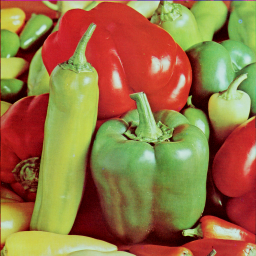

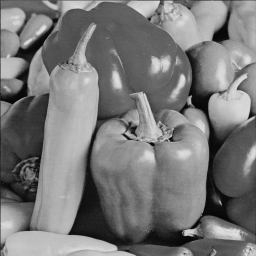

In [5]:
url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
img = skimage.io.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # openCV uses BGR (blue, green, red) representation
img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
cv2_imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

# 3.1 Discrete Fourier transform

One-dimensional discrete Fourier transform (DFT) of a signal x(n) is defined with the Eq. 3.1, and its inverse is defined with the Eq. 3.2:
\begin{equation}
X_k = \sum_{n=0}^{N-1}{x_n e^{-\frac{2\pi i}N kn}}, \qquad k = 0,...,N −1 \tag{3.1}
\end{equation}
\begin{equation}
x_n = \frac1N \sum_{k=0}^{N-1}{X_k e^{\frac{2\pi i}N kn}}, \qquad n = 0,...,N −1 \tag{3.2}
\end{equation}

If we define the matrix W as:
\begin{equation}
\mathbf{W}=\left[\begin{array}{cccc}
\omega_{N}^{0 \cdot 0} & \omega_{N}^{0 \cdot 1} & \ldots & \omega_{N}^{0 \cdot(N-1)} \\
\omega_{N}^{1 \cdot 0} & \omega_{N}^{1 \cdot 1} & \cdots & \omega_{N}^{1 \cdot(N-1)} \\
\vdots & \vdots & \ddots & \vdots \\
\omega_{N}^{(N-1) \cdot 0} & \omega_{N}^{(N-1) \cdot 1} & \ldots & \omega_{N}^{(N-1) \cdot(N-1)}
\end{array}\right]
\end{equation}

where $\omega_N = e^{-2\pi i/N}$, then the equations Eq. 3.1 and Eq. 3.2 can be rewritten in the matrix form:
\begin{equation} X = \mathbf{W}x \tag{3.3}\end{equation}   
\begin{equation} x = \mathbf{W}^{-1}X \tag{3.4}\end{equation}

Two-dimensional DFT of an image $x(m,n)$ is defined by:
\begin{equation}
X(k, l)=\sum_{n=0}^{N-1} \sum_{m=0}^{M-1} x(m, n) e^{-\frac{2 \pi i}{N} k n} e^{-\frac{2 \pi i}{N} l m}, \quad k \in[0, N-1], l \in[0, M-1] \tag{3.5}
\end{equation}

From Eq. 3.5, it is easy to see that the 2D DFT is a separable transform:
\begin{equation}
X(k,l) = \sum_{n=0}^{N-1}{e^{-\frac{2\pi i}N kn}} \sum_{m=0}^{M-1}{e^{-\frac{2\pi i}N lm}} x(m,n) \tag{3.6}
\end{equation}

i.e., that it is a combination of two 1D-DFT transforms. Since DFT is commonly calculated using the fast Fourier transform algorithm (FFT), we can calculate the 2D DFT first by calculating 1D DFT for each row (this is the intermediate result), followed by 1D DFT of each column of the intermediate result. Such an algorithm to computation of 2D DFT is called the row-column method. The complexity of the row-column method is $O(N^2log_2N)$. 2D DFT can be  calculated using the function [scipy.fft.fft2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft2.html), as explained in the following example:

## Example:

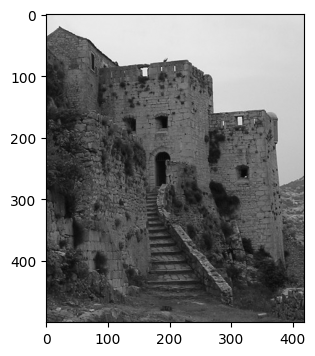

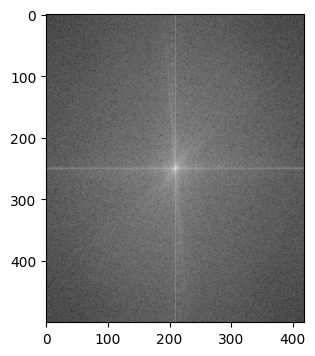

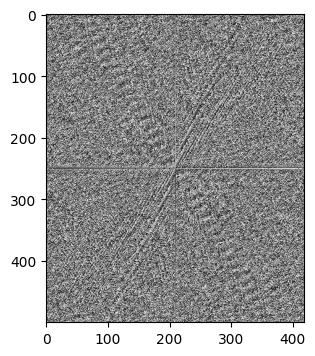

In [6]:
img = cv2.imread('/content/drive/MyDrive/Images/klis2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show the image
plt.figure(figsize = (4,4))
plt.imshow(img, cmap = 'gray')
plt.show()

# Compute Fourier transform
imgFT = fft2(img)
#imgFT = imgFT*2/np.prod(np.shape(imgFT))

# Shift central frequency (0) to image center for displaying - this isn't necessary but it can be visually more suitable
imgFT = fftshift(imgFT)

# Compute the amplitude and phase spectra
A = np.log10(np.abs(imgFT)) # amplitude in dB
phi = np.angle(imgFT)

plt.figure(figsize = (4,4))
plt.imshow(A, cmap='gray')
plt.show()
plt.figure(figsize = (4,4))
plt.imshow(phi, cmap='gray')
plt.show()

Functions *fft()* and *fft2()* calculate the spectrum whose center is not in the middle of the obtained matrix, but in the upper left corner. If we want to display the results so that the origin is in the middle of the image, we need to apply the function  [*fftshift()*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fftshift.html).

Usually DFT coefficients are scaled before displaying to see their correct values. But when displaying them as an image we want to normalize the image to be able to see the coefficients best. *plt.imshow* does that automatically, so there is no point in scaling the DFT coefficients. It is important to notice that **inputs of the functions *fft()* and *fft2()* should not be scaled or shifted!**

The spectrum which we calculated in our last example and saved in the variable imgFT is complex. Commonly, we display the complex spectrum by separately displaying the amplitude and the phase, which we define as:

\begin{equation}
A_{k}=\left|X_{k}\right|=\sqrt{\operatorname{Re}\left(X_{k}\right)^{2}+\operatorname{Im}\left(X_{k}\right)^{2}} \tag{3.07}
\end{equation}

\begin{equation}
\Phi_{k}=\arg \left(X_{k}\right)=\arctan \left(\operatorname{Im}\left(X_{k}\right), \operatorname{Re}\left(X_{k}\right)\right) \tag{3.08}
\end{equation}

Arctangent is a four quadrant function, so the signs (+/-) of real and imaginary part of the spectrum are relevant in the phase calculation. Since the differences between the coefficient values are commonly very large (up to several orders of magnitude), amplitude is usually displayed in decibels (dB), ie. the logarithm is applied to compress the dynamical range of the values.


### **3.1.1 Problems**
1. Select one image diplaying the natural scene (ie. klis.png) and one image of a texture (ie. uzorak.tif). Display their amplitudes and phases. Which part of the spectrum contains the largest portion of the energy?

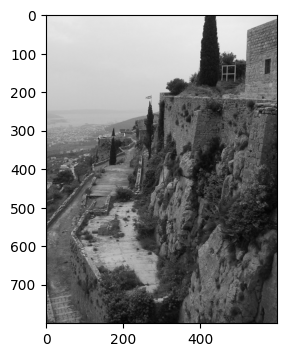

<ipython-input-7-8fc3d612ea70>:26: RuntimeWarning: divide by zero encountered in log10
  A_uzorak = np.log10(np.abs(img_uzorakFT))


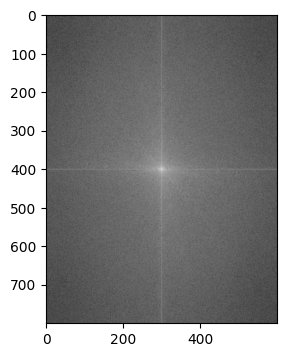

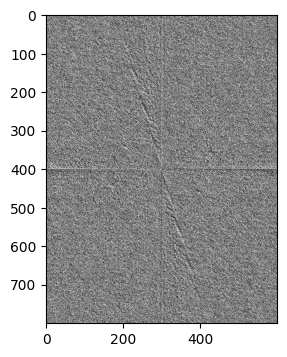

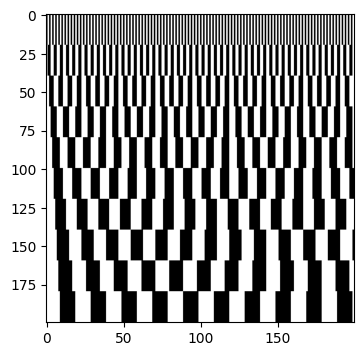

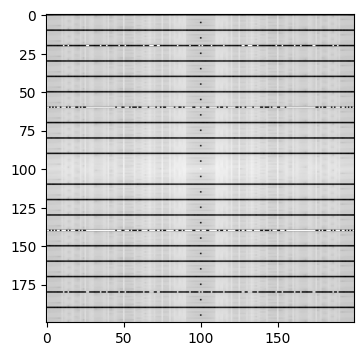

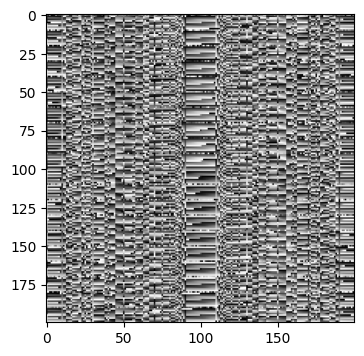

In [7]:
# Write-in your solution
img_klis_path = '/content/drive/MyDrive/Images/klis1.jpg'
img_uzorak_path = '/content/drive/MyDrive/Images/uzorak.tif'

img_klis = cv2.imread(img_klis_path)
img_klis = cv2.cvtColor(img_klis, cv2.COLOR_BGR2GRAY)
img_uzorak = cv2.imread(img_uzorak_path)
img_uzorak = cv2.cvtColor(img_uzorak, cv2.COLOR_BGR2GRAY)

# Show the image
plt.figure(figsize = (4,4))
plt.imshow(img_klis, cmap = 'gray')
plt.show()

# Compute Fourier transform
img_klisFT = fft2(img_klis)
img_uzorakFT = fft2(img_uzorak)
#imgFT = imgFT*2/np.prod(np.shape(imgFT))

# Shift central frequency (0) to image center for displaying - this isn't necessary but it can be visually more suitable
img_klisFT = fftshift(img_klisFT)
img_uzorakFT = fftshift(img_uzorakFT)

# Compute the amplitude and phase spectra
A = np.log10(np.abs(img_klisFT)) # amplitude in dB
A_uzorak = np.log10(np.abs(img_uzorakFT))
phi = np.angle(img_klisFT)
phi_uzorak = np.angle(img_uzorakFT)

plt.figure(figsize = (4,4))
plt.imshow(A, cmap='gray')
plt.show()
plt.figure(figsize = (4,4))
plt.imshow(phi, cmap='gray')
plt.show()

# Show the image
plt.figure(figsize = (4,4))
plt.imshow(img_uzorak, cmap = 'gray')
plt.show()

plt.figure(figsize = (4,4))
plt.imshow(A_uzorak, cmap='gray')
plt.axis('off')
plt.show()
plt.figure(figsize = (4,4))
plt.imshow(phi_uzorak, cmap='gray')
plt.axis('off')
plt.show()

Largest portion of energy is located in the low-frequency part of the spectrum, around the center of images.
In natural scenes (klis1.jpg), low frequencies dominate due to smooth transitions and large structures.
Textures (uzorak.tif) contain significant high-frequency components. However, the majority of the energy is concentrated in the low frequencies.

#3.2  2D DFT and the geometry transforms of the image

In this part of the exercise we will examine how do the basic geometry transforms such as scaling, rotation and translation of an image in the spatial domain affect its frequency spectrum. The scheme of the experiment is given in Fig. 3.1.

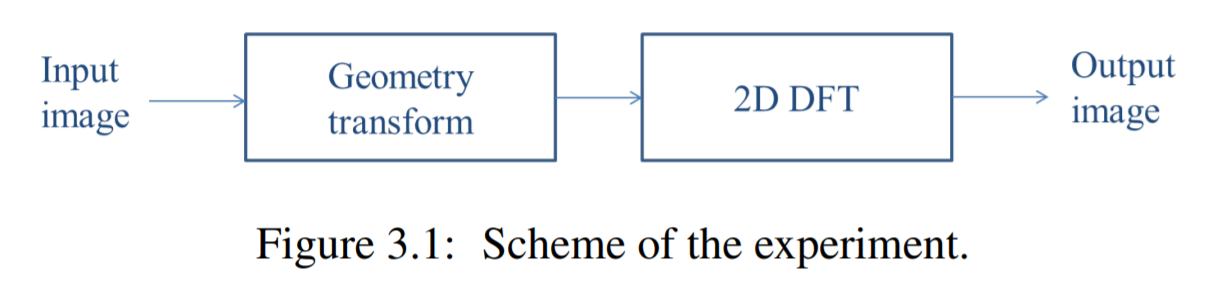



The size of the image can be varied with the function [cv2.resize()](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d). Rotation of an image for an angle θ is achieved by the transformation matrix of the form

\begin{equation} M=\begin{bmatrix} cosθ & −sinθ \\ sinθ & cosθ \end{bmatrix} \end{equation}

OpenCV provides scaled rotation with adjustable center of rotation so that you can rotate at any location you prefer. The modified transformation matrix is given by

\begin{equation} M=\begin{bmatrix} α & β & (1−α)⋅center.x−β⋅center.y\\ -β & α & β⋅center.x+(1−α)⋅center.y\end{bmatrix} \end{equation}
where:
\begin{equation} α=scale⋅cosθ \end{equation}
\begin{equation} β=scale⋅sinθ \end{equation}

To find this transformation matrix, OpenCV provides a function, [cv2.getRotationMatrix2D()](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326). Such a matrix is then passed to the [cv.warpAffine()](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983) function.

Translation is a geometric transformation which shifts image pizels by a certain amount. If you know the translation vector $(t_x,t_y)$, you can represent translation using the transformation matrix M as follows:
\begin{equation} M=\begin{bmatrix} 1 & 0 & t_x\\ 0 & 1 & t_y\end{bmatrix} \end{equation} and pass it into the cv.warpAffine() function.



## Example:

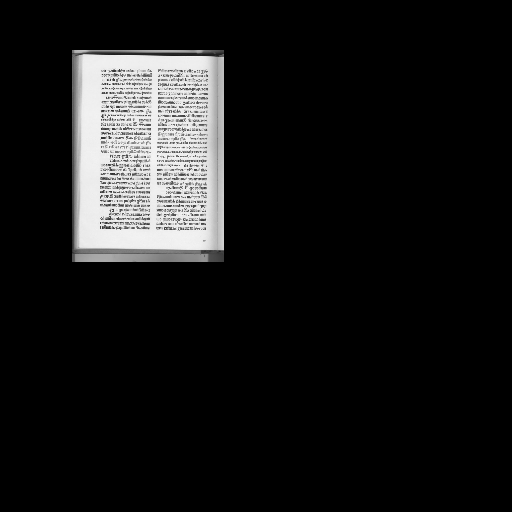

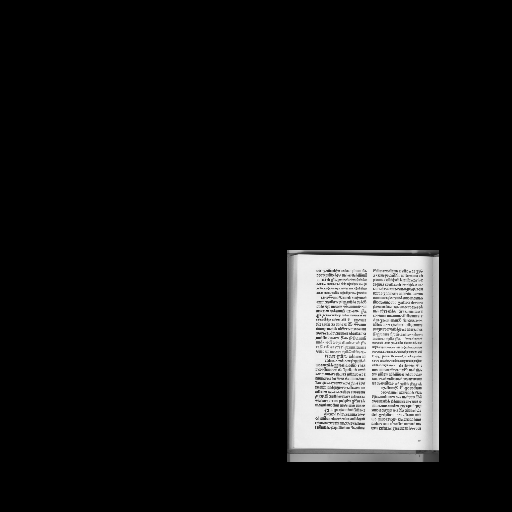

In [46]:
img = cv2.imread('/content/drive/MyDrive/Images/misal_1483.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imgL = cv2.resize(img, (img.shape[1] * 2, img.shape[0] * 2), interpolation = cv2.INTER_LINEAR)     # increase the image size 2 times, bilinear interpolation
imgS = cv2.resize(img, (img.shape[1] //4, img.shape[0] //4), interpolation = cv2.INTER_LINEAR)     # reduce the image size 4 times, bilinear interpolation
rows,cols = img.shape
M = cv2.getRotationMatrix2D(center=((cols-1)/2.0,(rows-1)/2.0), angle=66, scale=1)
imgR = cv2.warpAffine(img, M, (cols,rows))                                                         # rotate the image around the center by 66 deg

imgL1 = np.zeros((512,512))                                                                        # create a large matrix filled with zeros
imgL1[50:50+212,72:72+152]=imgS                                                                    # put the image imgS inside that matrix starting with the coordinates (50,72)
M = np.float32([[1,0,215],[0,1,200]])
rowsL1, colsL1 = imgL1.shape
imgL2 = cv2.warpAffine(imgL1,M, (colsL1, rowsL1))                                                  # translate the image by t_x columns and t_y rows

# cv2_imshow(imgL)
# cv2_imshow(imgS)
# cv2_imshow(imgR)
cv2_imshow(imgL1)
print()
cv2_imshow(imgL2)

### **3.2.1 Problems**

1. Select an arbitrary image. Calculate and display spectrum amplitudes of the original image and the same image scaled by an arbitrary factor. What is the difference?

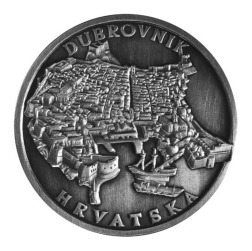

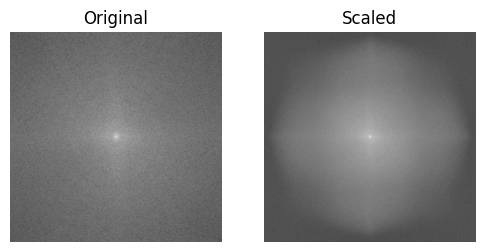

In [51]:
# Write-in your solution
img_path = '/content/drive/MyDrive/Images/medalja_dubrovnik.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# scaling x2
img_scaled = cv2.resize(img, (img.shape[1]*2, img.shape[0]*2), interpolation=cv2.INTER_LINEAR)

# Fourier
img_FT = fftshift(fft2(img))
img_scaled_FT = fftshift(fft2(img_scaled))

# Amplitude spectrums
A = np.log10(np.abs(img_FT))
A_scaled = np.log10(np.abs(img_scaled_FT))

# Display
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(A, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(A_scaled, cmap='gray')
plt.axis('off')
plt.show()

Scaling the image changes the spatial resolution, which affects the spread of the frequency components. When scaling the image up, the spectrum becomes more compressed around the center, indicating a concentration of energy at lower frequencies.

2. Select an arbitrary image. Calculate and display spectrum amplitudes of the original image and the same image rotated for an arbitrary angle. What is the difference?


In [10]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

3. Select an arbitrary image. Calculate and display spectrum amplitudes of the original image and the same image shifted (translated) for an arbitrary shift. What is the difference?

In [11]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

4. For the shifting case, can you tell from the spectrum phase where in the matrix the image is located?

In [12]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

# 3.3 Image filtering
Linear filtering of a spatially discrete image of dimension is performed by a 2D discrete linear system. In case of a 2D discrete linear shift invariant (LSI) system the output of 2D discrete linear system is calculated using the 2D linear convolution operation. To reduce computational complexity, instead of 2D linear convolution we would like to use multiplication in the DFT domain. However, we must be careful since multiplication in DFT domain corresponds to the circular convolution (and not linear convolution) in the spatial domain. For this reason, padding of both 2D sequences with zeros is required to make sure that the result of circular convolution is equal to the result of linear convolution. Let us assume that the image $x$ is of dimension $M_x × N_x$ and that the impulse response of the filter $h$ is of dimension $M_h × N_h$. In that case, both the image and the filter must be padded with zeros to the size $(M_x + M_h −1) × (N_x +N_h −1)$. After that we apply 2D DFT to both images, perform multiplication, followed by inverse 2D DFT to obtain the final result.


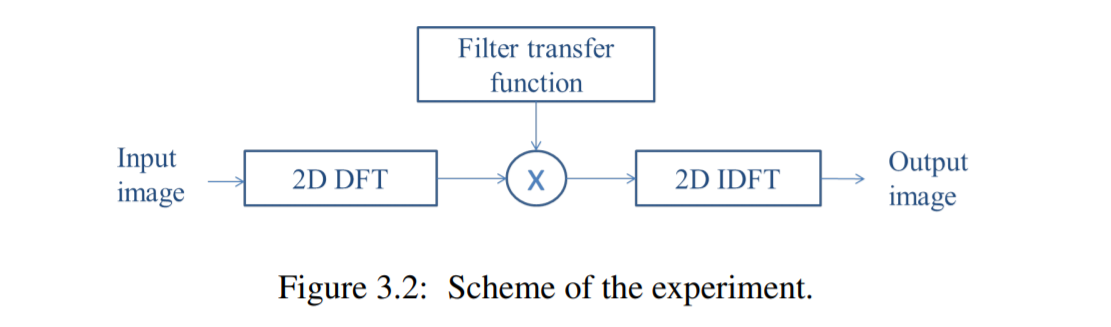

The transfer function of an LSI system equals to the DFT of the impulse response of the system but it can also be constructed directly in the DFT domain. For constructing the transfer function of an ideal filter, we can use Numpy.


## Example:

256 256


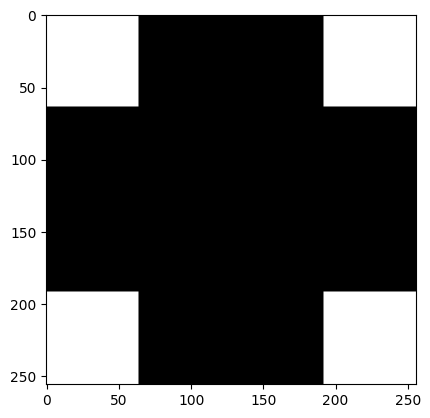

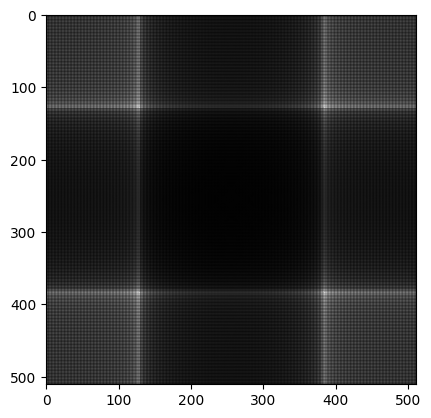

In [13]:
img = cv2.imread('/content/drive/MyDrive/Images/testpat1.tif')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

rows, cols = img.shape
print(rows, cols)

# create a low-pass filter, which passes half of the frequencies
filter = np.zeros((rows, cols))
rows = 256
cols = 256
filter[rows//4 : rows//4 + rows//2, cols//4 : cols//4 + cols//2] = np.ones((rows//2, cols//2))
filter = ifftshift(filter)
plt.imshow(filter, cmap='gray')
plt.show()

# then pad it with zeros in the spatial domain and apply DFT
h = np.real(ifft2(filter))
h_padded = np.zeros((511, 511))
h_padded[:256, :256] = h
plt.imshow(h_padded, cmap='gray')
filter_padded = fft2(h_padded)
plt.imshow(np.abs(filter_padded), cmap='gray')

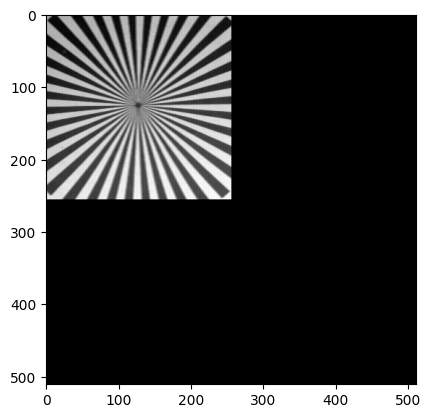

In [14]:
# zero-pad the image as well
img_padded = np.zeros((511, 511))
img_padded[:256, :256] = img
plt.imshow(img_padded, cmap='gray')
plt.show()

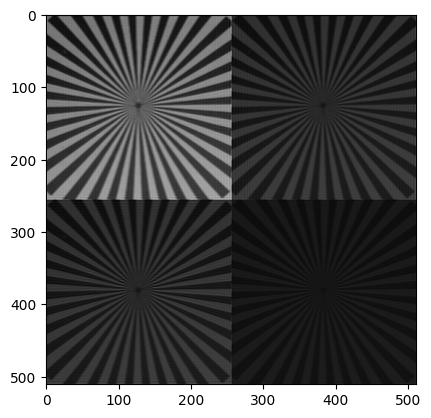

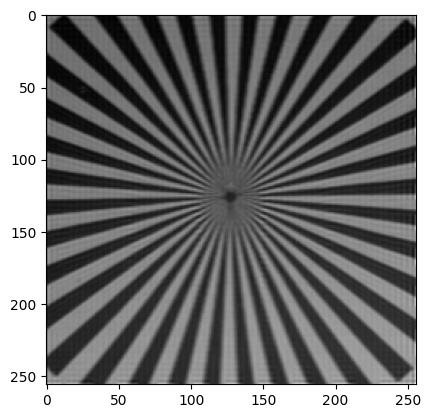

Maximum difference between linear and circular convolution: 2.9842794901924208e-12


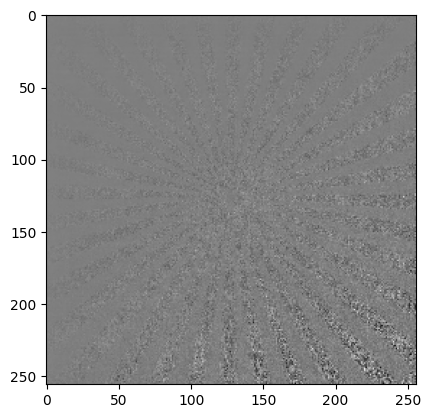

In [15]:
# multiply in the DFT domain
imgFT_padded = fft2(img_padded)
filt_imgFT = imgFT_padded * filter_padded

# apply inverse DFT and cut out the desired section - the section which contained the original images in the padded images
filt_img = np.real(ifft2(filt_imgFT))
plt.imshow(filt_img,cmap='gray')
plt.show()
filt_img = filt_img[:256, :256]
plt.imshow(filt_img,cmap='gray')
plt.show()

# comparison with linear convolution of img and h
conv_img=convolve2d(img, h, mode='full')
print("Maximum difference between linear and circular convolution:", np.amax(np.abs((conv_img[0:256,0:256]-filt_img))))
plt.imshow(conv_img[0:256,0:256]-filt_img, cmap='gray')
plt.show()

You can notice that the result of filtering is a complex matrix. Therefore, we need to apply *real()* or *abs(*) function on the result obtained after inverse transform. This operation is needed because of numerical errors that appear during the calculation of the impulse response, which cause complex values after IDFT calculation.

For calculation of the DFT, we assume that the signal is periodical. Therefore, the given procedure of multiplication in Fourier domain corresponds to the circular convolution. In 1D, circular or cyclic convolution is defined as:

\begin{equation}
\left(x_{N} * h\right)[n]=x_{N}[n] \circledast h_{N}[n]=\sum_{m=-\infty}^{\infty} h[m] \cdot x_{N}[n-m]=\sum_{m=-\infty}^{\infty}\left(h[m] \cdot \sum_{k=-\infty}^{\infty} x[n-m-k N]\right) \tag{3.09}
\end{equation}

If we extend our signals x[n] and h[n] to be periodical with a period $N$ (lets call these periodical signals $\tilde{x}[n]$ and $\tilde{h}[n]$), then the linear convolution of these signals is periodical, and one period of this periodical linear convolution corresponds to the circular convolution.
In 2D, we can write this **expression for circular convolution**:
\begin{equation}
y[m, n]=\sum_{i=0}^{M_{x}-1} \sum_{j=0}^{N_{x}-1} x[i, j] h\left[(m-i) \% M_{x},(n-i) \% N_{x}\right] \tag{3.10}
\end{equation}

where $\%$ denotes the modulus operator, $M_x$ and $N_x$ denote the dimensions of the image $x[i, j]$, with $ M_x > M_h$ and $N_x > N_h$.

If we want to calculate the linear convolution using the computationally more efficient DFT (ie. FFT!), we have to reduce linear convolution to circular convolution. To achieve this, signals (or images) $x(i, j)$ and $h(i, j)$ need to be padded with zeros so that the dimensions of both of them are at least $(Mx + Mh −1) × (Nx +Nh −1)$. The desired result of the linear convolution is now within the calculated DFT matrix, which we can approach to by cutting off the extra values that do not contain the desired information. This cutting will depend on the way we padded our signals with zeros.

### **3.3.1 Problems**

1. Select one image from the USC-SIPI image database. Examine and describe the effect of: a) lowpass, b) high-pass, c) band-pass and d) band-stop filters on the image. Perform the filtering by direct
multiplication in the frequency domain.

In [16]:
# Write-in your solution

**WRITE YOUR ANSWER HERE**

# 3.4 Discrete cosine transform

Discrete cosine transform (DCT) is another orthogonal linear transform, which has certain properties that are important in specific applications. DCT is a real transform, which means that DCT coefficients of a real image are real numbers (as opposed to DFT).

One-dimensional (1D) DCT is defined as:

\begin{equation}
X[k]=\alpha(k) \sum_{n=0}^{N-1} x[n] \cos \frac{(2 n+1) k \pi}{2 N} \tag{3.11}
\end{equation}

where $α(k)$ denotes a normalization coefficient defined as From these two expressions we can derive a single expression for calculating the DCT in 1D:

\begin{equation}
X[k]=\sqrt{\frac{2-\delta[k]}{N}} \sum_{n=0}^{N-1} x[n] \cos \frac{(2 n+1) k \pi}{2 N} \tag{3.12}
\end{equation}

\begin{equation}
\alpha(k)=\left\{\begin{array}{ll}
\sqrt{\frac{1}{N}}, & k=0 \\
\sqrt{\frac{2}{N}}, & 1 \leq k< N
\end{array}\right.
\end{equation}

2D DCT is defined as:

\begin{equation}
X\left[k_{1}, k_{2}\right]=\alpha\left(k_{1}, k_{2}\right) \sum_{n_{1}=0}^{N_{1}-1} \sum_{n_{2}=0}^{N_{2}-1} x\left(n_{1}, n_{2}\right) \cos \frac{\left(2 n_{1}+1\right) k_{1} \pi}{2 N_{1}} \cos \frac{\left(2 n_{2}+1\right) k_{2} \pi}{2 N_{2}} \tag{3.13}
\end{equation}

Here, normalizing is obtained by multiplication with a normalization coefficient $α(k1, k2)$, defined as $α×α^T$



In the following example [scipy.fft.dct](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html#scipy.fft.dct) and [scipy.fft.idct](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.idct.html) are used.

## Example:

In [17]:
img = cv2.imread('/content/drive/MyDrive/Images/klis2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imgCT=dct(img) # Calculate DCT
imgO=idct(img) # Calculate IDCT
# the values aren't complex

# 3.5 DCT and image compression
As we could have seen in the previous chapter, most of the energy is distributed in the low-frequency components of the spectrum. This is true only when we’re talking about the images displaying natural scenes. This property of DCT can be used for image compression which can be separated in three steps: DCT transform,
basis restriction and coefficient quantization. Unlike before, the transform is not performed once for the whole image, but block-wise - with block sizes $8× 8$ or $16× 16$. Then, for each block DCT is calculated and and the coefficients are quantized. Quantized coefficients are are then coded with Huffman algorithm.

Here, we give an example for calculating the DCT transform of the image img in blocks 8×8.



## Example:

(300, 613)


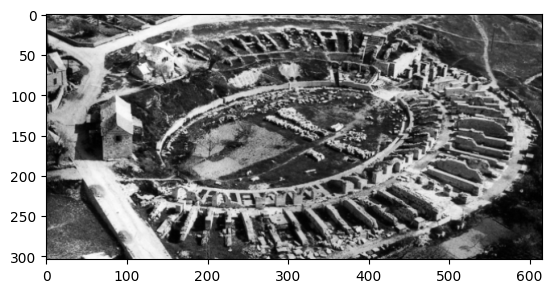

In [18]:
img = cv2.imread('/content/drive/MyDrive/Images/salona.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(img.shape)
img = cv2.resize(img, (616, 304), cv2.INTER_LINEAR)
img = np.reshape(img, (img.shape[0]//8, 8, img.shape[1]//8, 8))

imgDCT = dct(dct(img, axis=1), axis=3)
imgIDCT = idct(idct(imgDCT, axis=1), axis=3)

imgIDCT = np.reshape(imgIDCT, (img.shape[0]*8, img.shape[2]*8))
plt.imshow(imgIDCT, cmap='gray')

Now we need to apply the basis restriction to each block of the calculated transform. If the variable *mask* is a matrix that contains the basis restriction mask, the restriction can be performed using the following code:

[[1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


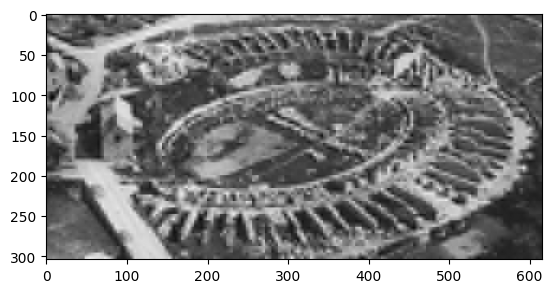

In [19]:
#mask = np.ones((8,8))
mask = np.zeros((8,8))
mask[:2,:2] = np.ones((2,2))
print(mask)
mask = np.reshape(mask, (1, 8, 1, 8))

imgDCT = dct(dct(img, axis=1), axis=3)
imgDCT = imgDCT * mask
imgIDCT = idct(idct(imgDCT, axis=1), axis=3)

imgIDCT = np.reshape(imgIDCT, (img.shape[0]*8, img.shape[2]*8))
plt.imshow(imgIDCT, cmap='gray')

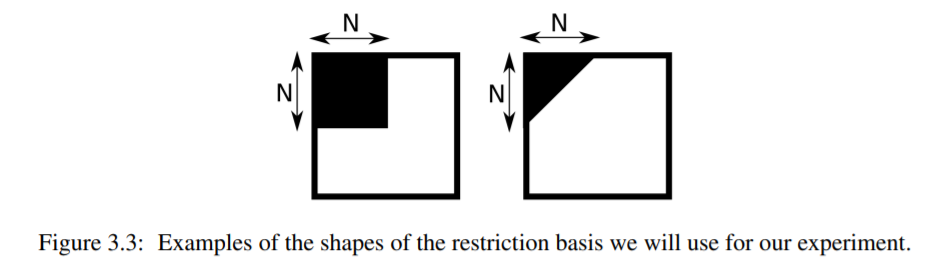

### **3.5.1 Problems**

1. Write the function that calculates an 8 × 8 matrix which will represent the basis restriction mask. Input parameters of the functions should be: 1) shape of the mask, and 2) size of the mask. The examples of the triangle and the square masks are given in Fig. 3.3, where the dark pixels represent the value 1, and the bright pixels represent the value 0. N denotes the size of the mask.

In [20]:
# Write-in your solution

2. Select one image from the USC-SIPI image database. Calculate the DCT with a block size 8×8 and apply the basis restriction. Display the original and the reconstructed image.

In [21]:
# Write-in your solution

3. Calculate the mean square error (MSE) of the original image compared to the image reconstructed in the previous task.


In [22]:
# Write-in your solution

4. Try different masks for the basis restrictions and compare the reconstructed results (bot visually and by calculating the MSE with respect to the original image). What can you conclude?

In [23]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

5. Calculate MSE for the case when, besides the basis restriction, we also perform the coefficient quantization.


In [24]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

# 4.1 First order histogram

For grayscale images, the first order histogram represents a relative frequency of the appearance of different levels of gray in the image.

The first order histogram can be both calculated and displayed by calling the function [numpy.histogram()](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html).

## Example:

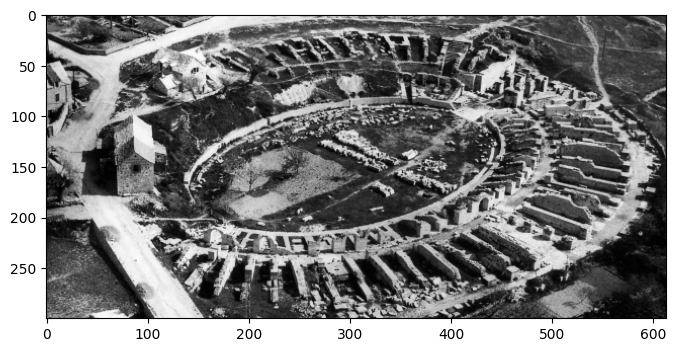

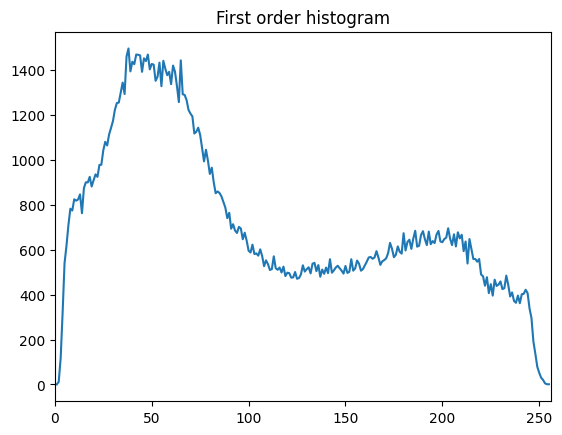

In [25]:
salona = cv2.imread('/content/drive/MyDrive/Images/salona.png')
salona = cv2.cvtColor(salona, cv2.COLOR_BGR2GRAY)

# Show the image
plt.figure(figsize = (8,8))
plt.imshow(salona, cmap = 'gray')
plt.draw()

# Calculate the first order histogram
histogram, bin_edges = np.histogram(salona, bins = 256, range = (0, 256))

# Plot the histogram
plt.figure()
plt.title("First order histogram")
plt.xlim((0, 256))

plt.plot(bin_edges[:-1], histogram)
plt.show()

For RGB images, we can calculate the first order histogram for each channel separately.

## Example:

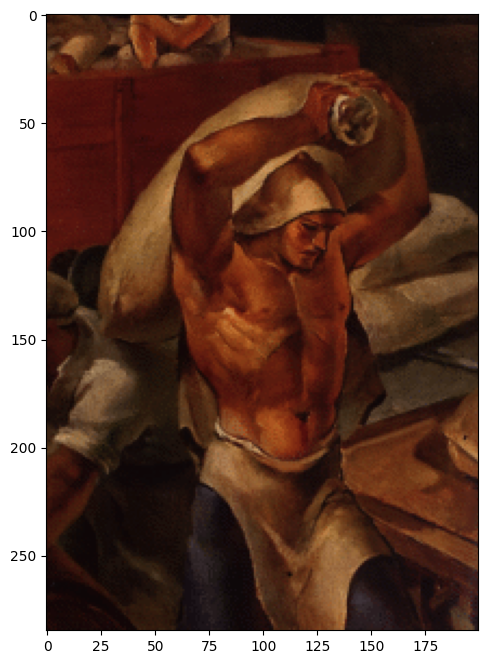

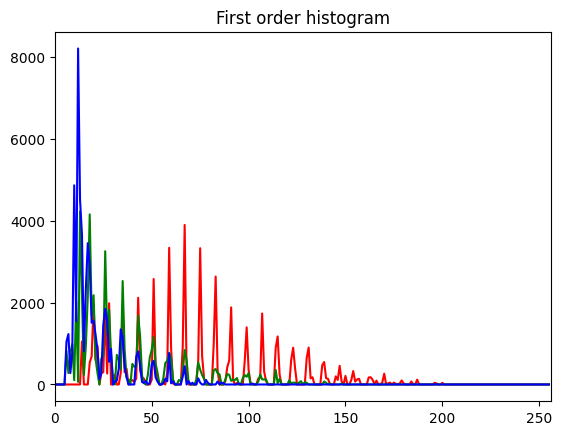

In [26]:
detalj = cv2.imread('/content/drive/MyDrive/Images/detalj.png')
detalj = cv2.cvtColor(detalj, cv2.COLOR_BGR2RGB)

# Show the image
plt.figure(figsize = (8,8))
plt.imshow(detalj, cmap = 'gray')
plt.draw()

# Plot the histogram with three lines, one for each color / channel
plt.figure()
plt.title("First order histogram")
plt.xlim([0, 256])

for i, c in enumerate("rgb"):
    # Calculate the first order histogram for channel c
    histogram, bin_edges = np.histogram(detalj[:,:,i], bins=256, range=(0, 256))

    plt.plot(bin_edges[:-1], histogram, color = c)

plt.show()

### **4.1.1 Problems**

1. Select several images and display their first order histograms. What do the axes of the histograms represent?

In [27]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

# 4.2 Histogram equalization

Histogram equalization is an operation which changes the histogram of an image so that the number of pixels is approximately equal for all brightness levels.

## Example:

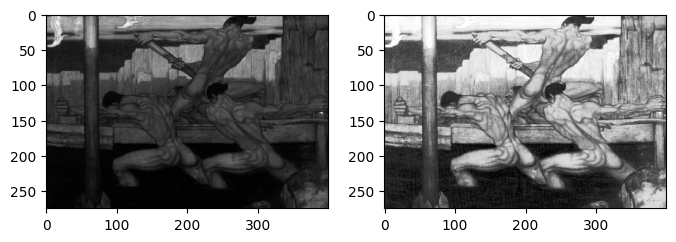

In [28]:
uskoci1 = cv2.imread('/content/drive/MyDrive/Images/uskoci1.png')
uskoci1 = cv2.cvtColor(uskoci1, cv2.COLOR_RGB2GRAY) # Convert to grayscale

# Equalize the histogram by calculating the cumulative distribution function
# of the image
cdf, bin_centers = skimage.exposure.cumulative_distribution(uskoci1)
result = skimage.img_as_ubyte(np.interp(uskoci1, bin_centers, cdf))

# Plot the original and the equalized image
plt.figsize=(8, 8)
fig, axs = plt.subplots(1, 2, figsize = (8, 16))
axs[0].imshow(uskoci1, cmap='gray')
axs[1].imshow(result, cmap='gray')
fig.show()

### **4.2.1 Problems**

1. Read the images uskoci1.png and salona.png. Display their first order histograms before and after the histogram equalization.

In [29]:
# Write-in your solution

2. Do you see more details in the images before or after equalization?

**WRITE YOUR ANSWERS HERE**

# 4.3 Histogram modeling

If the function $F$ denotes a [cumulative function distribution (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) and $F^{-1}$ denotes its [inverse](https://en.wikipedia.org/wiki/Inverse_function), and if $U$ denotes a set of number with a [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) on an interval [0,1], then a set of numbers $F^{-1}(U)$ has a pixel value distribution equal to $F$. This fact can be used for histogram modeling.

## Example:

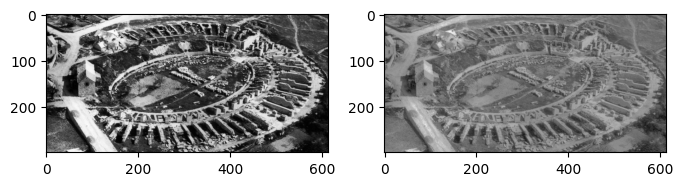

In [30]:
salona = cv2.imread('/content/drive/MyDrive/Images/salona.png')
salona = cv2.cvtColor(salona, cv2.COLOR_BGR2GRAY)

# Equalize the histogram by calculating the cumulative distribution function
# of the image

#After the equalization, the image will have an (approximately) uniform distribution
cdf, bin_centers = skimage.exposure.cumulative_distribution(salona)
result = np.interp(salona, bin_centers, cdf)

result = norm.ppf(result, loc = 0, scale = 10) # Inverse of N(0, 100)
                                               # Imported from scipy.stats

# Plot the original and the modeled image
fig, axs = plt.subplots(1, 2, figsize=(8, 16))
axs[0].imshow(salona, cmap='gray')
axs[1].imshow(result, cmap='gray')
fig.show()

### **4.3.1 Problems**

1. Choose an arbitrary image. Model its histogram to obtain the logistic distribution.

*Hint: try using the [scipy.stats.logistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.logistic.html) class*

In [31]:
# Write-in your solution

2. Read the image auto.tif. Model its histogram until the number on the car’s registration plate becomes visible.

*Hint: Check the interval of pixel values in the register plate area, and determine the mapping of this interval to a larger one.*

In [32]:
# Write-in your solution

# 4.4 Average filtering and median filtering

In this part of the exercise we will compare a statistical median filter and a regular averaging filter with a purpose of image denoising. The scheme of the experiment is given in Fig. 4.1.

We can add a noise to the image by calling the function [skimage.util.random_noise()](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.random_noise).

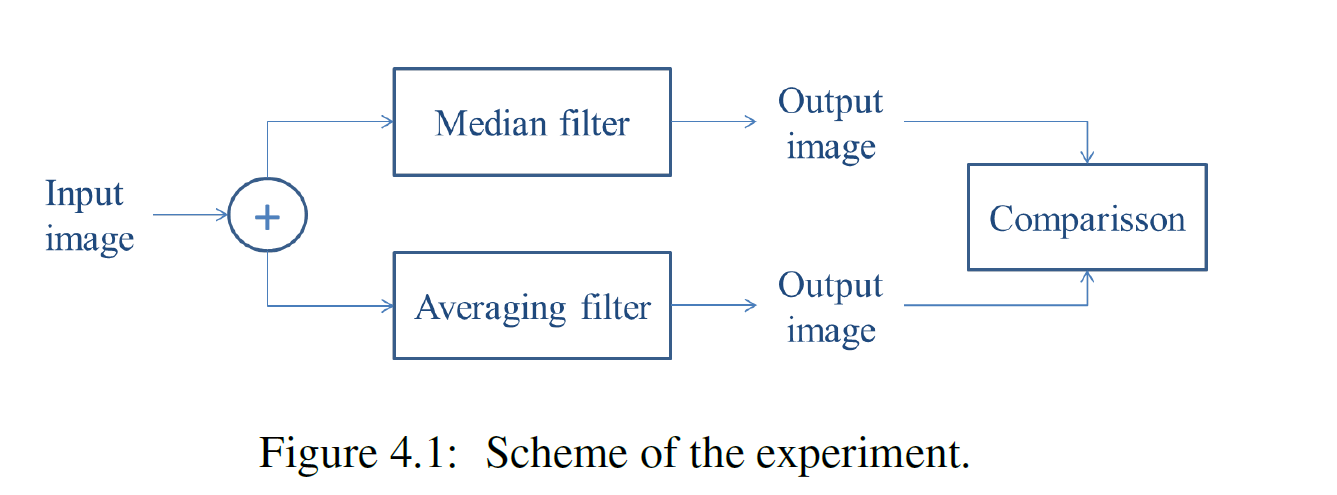

## Example:

In [33]:
medalja = cv2.imread('/content/drive/MyDrive/Images/medalja_dubrovnik.png')
medalja = cv2.cvtColor(medalja, cv2.COLOR_BGR2GRAY)

# Adding various noises
medaljaGN = skimage.img_as_ubyte(skimage.util.random_noise(medalja,
                                                           mode = 'gaussian',
                                                           clip = True,
                                                           var = 0.1))

medaljaSP = skimage.img_as_ubyte(skimage.util.random_noise(medalja,
                                                           mode = 's&p',
                                                           amount = 0.3))

Median filter is a statistical filter which is applied block-wise in image processing: for each input block of a given size the filter results with a median value of this block.

Median filtering can be performed by using the function [scipy.signal.medfilt2d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt2d.html).

Averaging, which also can be viewed as a statistical filter, can be obtained with convolution.

## Example:

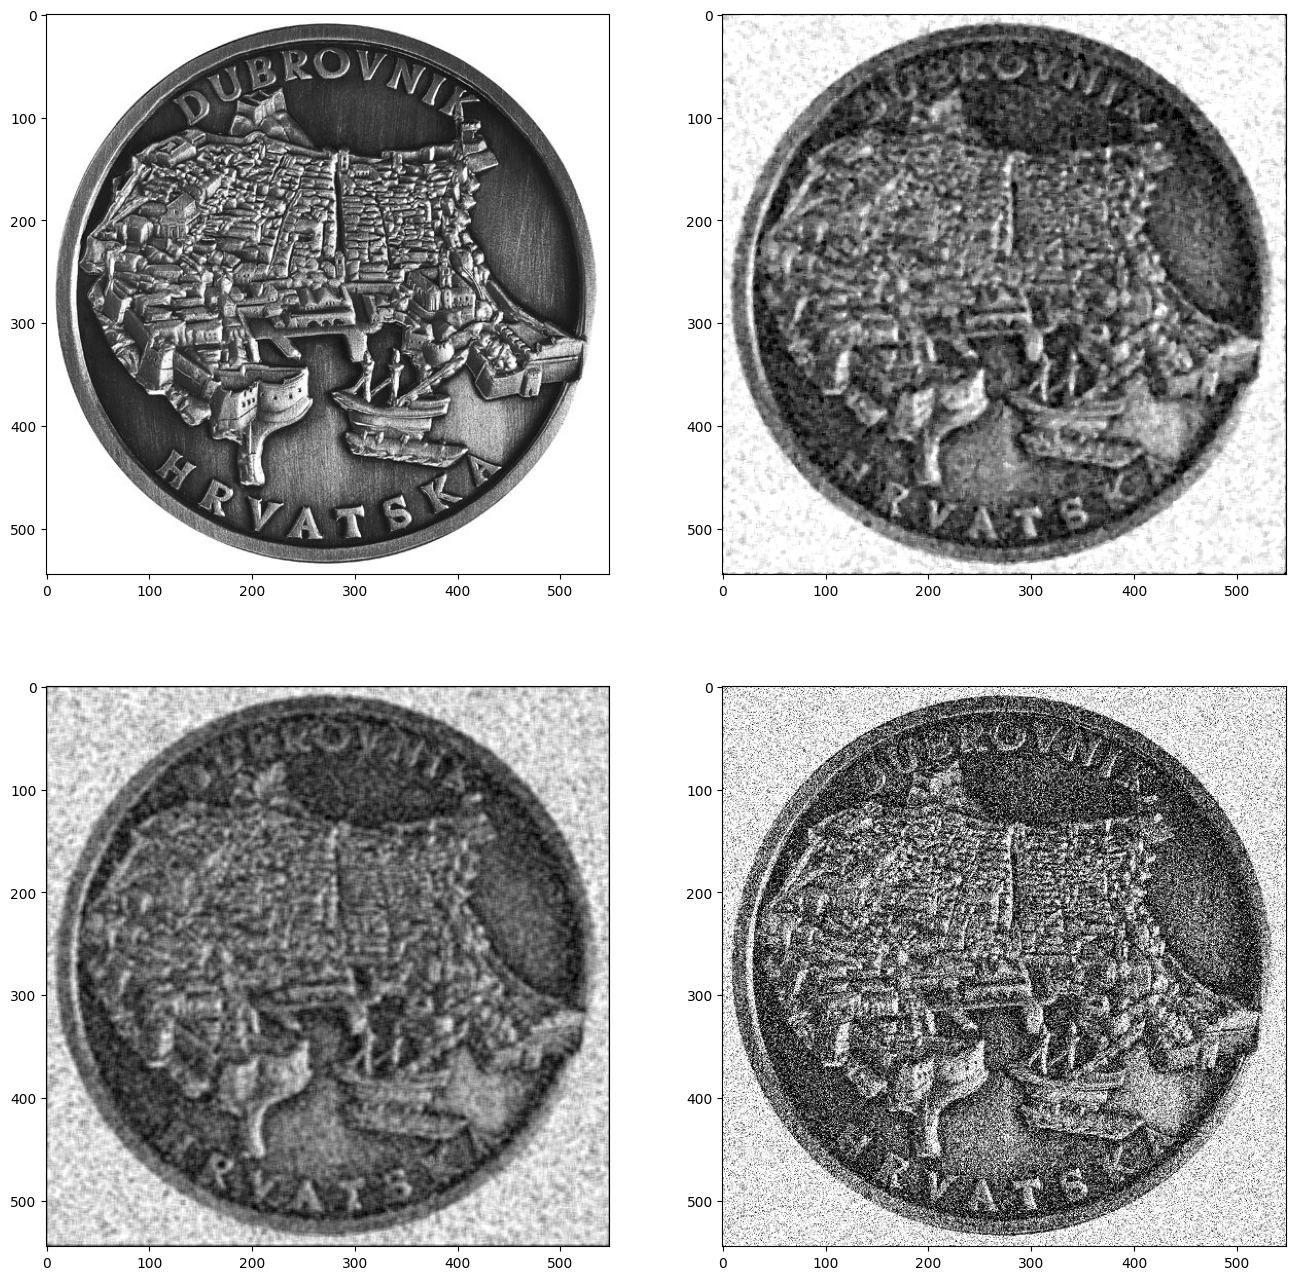

In [34]:
# Filtering the noise with a median filter, block size 5x5
medaljaMF = medfilt2d(medaljaGN, kernel_size = 5)

# Creating an 5x5 averaging mask
mask = np.ones((5, 5))
mask = mask / np.sum(mask)

medaljaAF = convolve2d(medaljaSP,
                       mask,
                       mode = 'same')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs[0, 0].imshow(medalja, cmap='gray')
axs[1, 1].imshow(medaljaGN, cmap='gray')
axs[0, 1].imshow(medaljaMF, cmap='gray')
axs[1, 0].imshow(medaljaAF, cmap='gray')
fig.show()

### **4.4.1 Problems**

1. Choose another arbitrary image.
Create 2 noisy images from it: one by adding the Gaussian noise and the other one by adding the salt&pepper noise.

In [35]:
# Write-in your solution

2. Try denoising these images with median and averaging filters. Comment on the results. Which filter is more appropriate for which type of the noise?

In [36]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

# 4.5 Unsharpness removal

First attempts of removing the unsharpness from an image consisted of subtracting the blurred version of
an image from the original image. More precisely, the unsharpness is removed using the below written equation, where $A$ denotes a positive number larger than 1, and $I_{lf}$ denotes a blurred version of the image (ie. the low-pass filtered image).

$$I_{hb}(x,y) = AI(x,y) - I_{lf}(x,y)$$

The first applications of this method were registered in Germany in 1930s. However, we can observe this procedure from another point of view, i.e. instead of subtracting the blurred image from the original one, we can add the image with the emphasized edges to the original one. If the image $I$ consists of low and high derivatives ($I = I_{lf} +I_{hf}$), then the afromentioned equation can be rewritten as:

$$ I_{hb}(x,y) = AI_{hf}(x,y) + AI_{lf}(x,y) - I_{lf}
(x,y) = (A - 1)I_{lf}(x,y) + AI_{hf}(x,y) $$

From the obtained expression, we can see that we can increase the sharpness of a blurred image by adding proper high frequencies to it. This procedure is also called *high-boost* filtering, therefore we denote the output image as $I_{hb}$. The biggest problem of this procedure is to obtain the high frequencies of the image. In this exercise we will estimate them by means of derivative estimations. The scheme of the experiment is given in Fig. 4.2. The image is blurred with an averaging mask of an arbitrary size, i.e. 3x3.

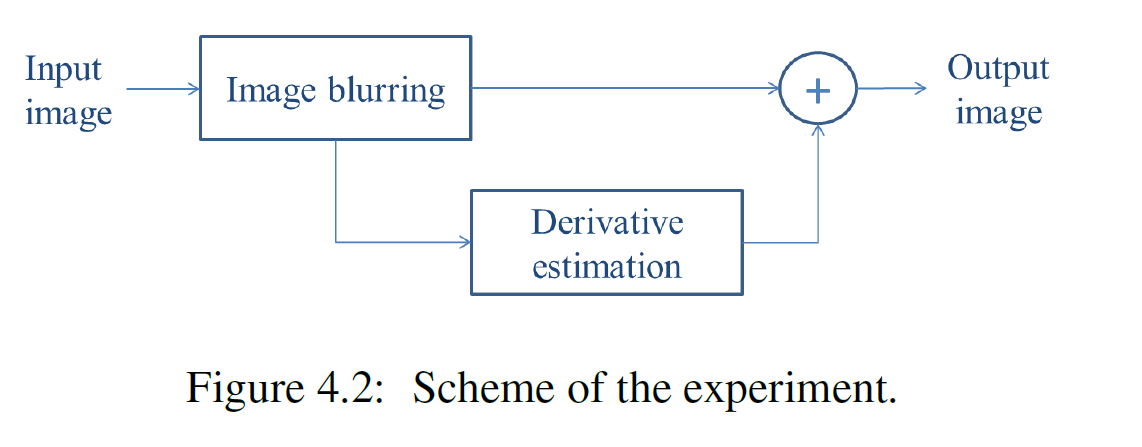

## Example:

In [37]:
blood1 = cv2.imread('/content/drive/MyDrive/Images/blood1.tif')
blood1 = cv2.cvtColor(blood1, cv2.COLOR_BGR2GRAY)

# Creating an 3x3 averaging mask
mask = np.ones((3, 3))
mask = mask / np.sum(mask)

# Blurring the image with an averaging filter
bloodAF = convolve2d(blood1,
                     mask,
                     mode = 'same')

In a case of one-dimensional signal, the derivative in a point x can be approximated by using the following expression:

$$ \Delta(x) = \frac{f(x+h) - f(x)}{h} $$

In a two-dimensional case, the derivative has its direction and its value and can be estimated with some of existing operators. In our experiment, we will estimate the first derivative, i.e. the gradient, with a [Sobel
operator](https://en.wikipedia.org/wiki/Sobel_operator), and the second derivative with a [Laplace operator](https://en.wikipedia.org/wiki/Laplace_operator).

For that purpose, we use the functions [skimage.filters.sobel_h()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel_h), [skimage.filters.sobel_v()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel_v), and [skimage.filters.laplace()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.laplace) for convolving with the respective operator estimation.

## Example:

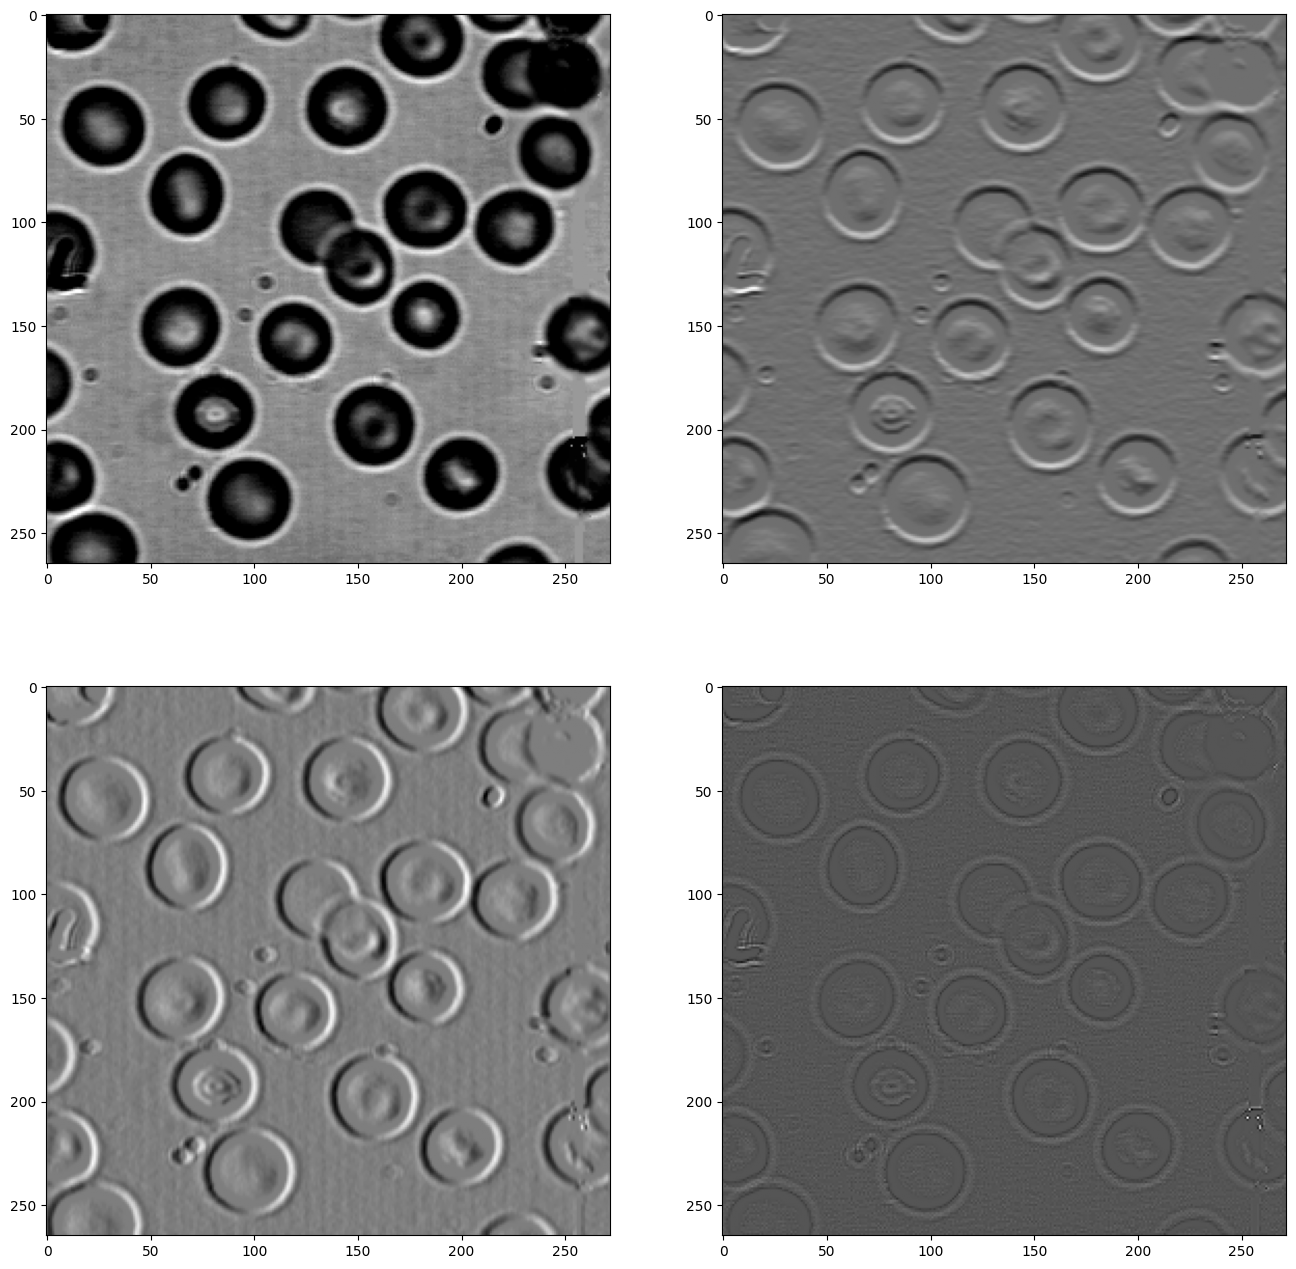

In [38]:
# Plot the original image and its estimated derivatives
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs[0, 0].imshow(blood1, cmap='gray')
axs[1, 1].imshow(laplace(blood1), cmap='gray')
axs[0, 1].imshow(sobel_h(blood1), cmap='gray')
axs[1, 0].imshow(sobel_v(blood1), cmap='gray')
fig.show()

### **4.5.1 Problems**

1. Choose an arbitrary image and perform the procedure explained with a scheme in a Fig. 4.2. Display the difference between the images. How satisfied are you with the increased sharpness (reconstruction)?

In [39]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

2. Read the image medalja_dubrovnik.png and increase its sharpness by subtracting its blurred version (according to the first equation of this chapter). What did you obtain with this procedure?

In [40]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

3. Read the image medalja_dubrovnik.png and increase its sharpness by adding its first derivative estimation, obtained by Sobel operator (according to the second equation of this chapter). What did you obtain?

In [41]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

4. Read the image 5.1.09.tiff from the USC-SIPI database and try to increase the sharpness by adding the first derivative (gradient) and the second derivative (Laplace operator). Which of these methods gives better results?

In [42]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

5. Try both methods (adding the 1st and the 2nd derivative estimation) on two more images. What is the relevant difference between adding the 1st and the 2nd derivative to an image? Which method gives better results?

In [43]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**